## Demonstration of Single-Cell Benchmark Tasks
### Using cz-benchmarks to evaluate a model on multiple tasks

This notebook demonstrates how to leverage the `czbenchmarks` library to evaluate single-cell models on multiple benchmark tasks. `czbenchmarks` is a Python library designed to streamline benchmarking for single-cell analysis tasks, such as clustering, embedding, and cell type classification. 


For demonstration purposes, we use `scVI`and showing performance of the published model weights for each of the following tasks: 
* `Clustering`
* `Embedding`
* `Cell Type Classification`

### Step 1: Setup and Imports

The set-up for steps #1 - #3 mirrors that shown in `scvi_model_dev_workflow.ipynb`.

In [3]:
# # Create isolated virtual environment for scVI and czbenchmarks (run once)

# !python3 -m venv .venv_scvi

# # Install model required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn

# # Register the new environment as a Jupyter kernel (if not already registered)
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment '.venv_scvi' created, dependencies installed, and kernel registered.")

In [ ]:
import sys
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput

# Model specific imports
import scvi  # other imports can be used as required by model
import functools

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook config imports
import warnings 

warnings.simplefilter('ignore')
sns.set_theme(style="whitegrid")

/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2: Load a Dataset

Load the pre-configured `tsv2_prostate` dataset. The library handles automatic download, caching, and loading as a `SingleCellLabeledDataset` for streamlined reuse.

**Loaded dataset provides:**
- `dataset.adata`: AnnData object with gene expression data.
- `dataset.labels`: pandas Series of cell type labels.

In [5]:
# The 'dataset' object is a validated AnnData wrapper, ensuring efficient downstream processing.
try:
    # Load the dataset
    dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
except Exception as e:
    print(f"Error loading dataset: {e}")
    sys.exit(1)

INFO:czbenchmarks.file_utils:File already exists in cache: /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad
INFO:czbenchmarks.datasets.single_cell:Loading dataset from /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad


### Step 3: Obtain pre-trained model, Run model inference, and Get output
Obtain the model weights associated with the pre-trained scVI model to use as a reference. Generate cell embeddings for evaluation within the benchmarking framework.

In [6]:
model_weights_dir = "czbenchmarks_scvi_model"
required_obs_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]

adata = dataset.adata.copy()

batch_keys = required_obs_keys
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) for c in batch_keys]
)
# Use the scvi-tools API to map our dataset to the reference model
try:
    # Load pre-trained model weights
    scvi.model.SCVI.prepare_query_anndata(adata, model_weights_dir)
    scvi_model = scvi.model.SCVI.load_query_data(adata, model_weights_dir)
    scvi_model.is_trained = True  # Ensure the model is marked as trained
except FileNotFoundError:
    print(f"Model weights not found in directory: {model_weights_dir}")
    sys.exit(1)
except Exception as e:
    print(f"Error loading model weights: {e}")
    sys.exit(1)

# Now, generate the latent representation (the embedding)
scvi_embedding = scvi_model.get_latent_representation()
model_output = scvi_embedding

print(f"Generated scVI embedding with shape: {scvi_embedding.shape}")

INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
INFO     Found 44.05% reference vars in query data.                                                                
INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
Generated scVI embedding with shape: (2044, 50)


### Step 4A: Run the Clustering Task

Here, we generate benchmark task results for the pre-trained model and the associated baseline (PCA).

In [7]:
all_results = {}
# This step evaluates the clustering performance of the scVI model and compares it to a PCA baseline.


# 1. Initialize the task
clustering_task = ClusteringTask()

# 2. Define the inputs for the task  (metadata and labels from the dataset)
clustering_task_input = ClusteringTaskInput(
    obs=dataset.adata.obs,
    input_labels=dataset.labels,
)

# 3. Run the task on your scVI model's output embeddings
clustering_results = clustering_task.run(
    cell_representation=model_output,
    task_input=clustering_task_input,
)

# 4. Compute and run the baseline for comparison
expression_data = dataset.adata.X
clustering_baseline = clustering_task.compute_baseline(expression_data)
clustering_baseline_results = clustering_task.run(
    cell_representation=clustering_baseline,
    task_input=clustering_task_input,
)

# Store results for downstream use
all_results["clustering"] = {
    "model": [r.model_dump() for r in clustering_results],
    "baseline": [r.model_dump() for r in clustering_baseline_results],
}

                         metric_type     value params        source  \
0     MetricType.ADJUSTED_RAND_INDEX  0.728258     {}    scVI Model   
1  MetricType.NORMALIZED_MUTUAL_INFO  0.869382     {}    scVI Model   
0     MetricType.ADJUSTED_RAND_INDEX  0.626707     {}  PCA Baseline   
1  MetricType.NORMALIZED_MUTUAL_INFO  0.832648     {}  PCA Baseline   

              metric_name  
0     ADJUSTED_RAND_INDEX  
1  NORMALIZED_MUTUAL_INFO  
0     ADJUSTED_RAND_INDEX  
1  NORMALIZED_MUTUAL_INFO  


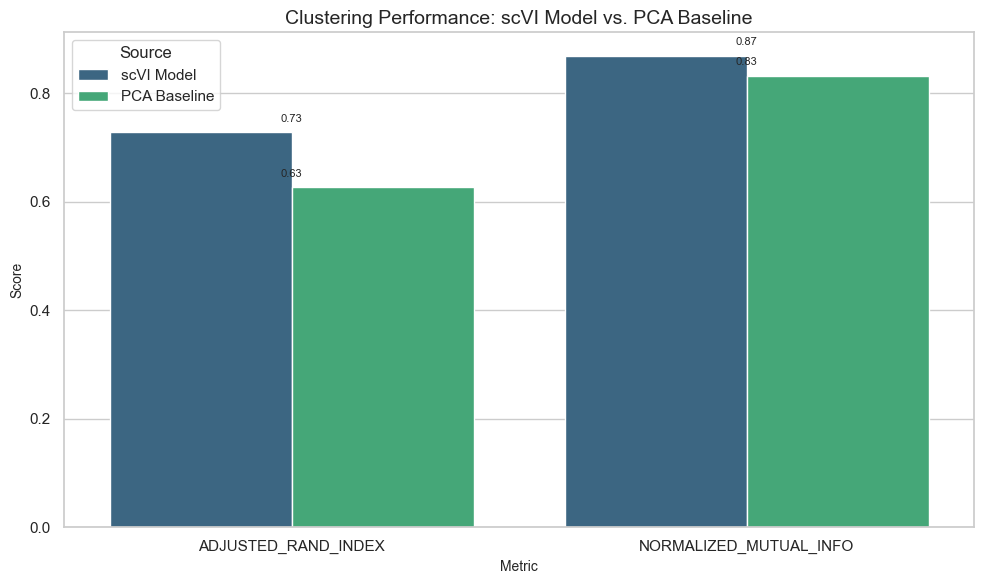

In [8]:
# Prepare DataFrame for plotting
df_clustering_model = pd.DataFrame(all_results["clustering"]["model"])
df_clustering_baseline = pd.DataFrame(all_results["clustering"]["baseline"])
df_clustering_model["source"] = "scVI Model"
df_clustering_baseline["source"] = "PCA Baseline"
df_clustering = pd.concat([df_clustering_model, df_clustering_baseline])
df_clustering["metric_name"] = df_clustering["metric_type"].apply(lambda x: x.name)

print(df_clustering)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_clustering, x="metric_name", y="value", hue="source", palette="viridis")
plt.title("Clustering Performance: scVI Model vs. PCA Baseline", fontsize=14)
plt.ylabel("Score", fontsize=10)
plt.xlabel("Metric", fontsize=10)
plt.xticks(rotation=0)
plt.legend(title="Source")
plt.tight_layout()

# Add annotations to highlight differences
for index, row in df_clustering.iterrows():
    plt.text(
        index,
        row["value"] + 0.02,
        f"{row['value']:.2f}",
        ha="center",
        fontsize=8,
    )
    
plt.show()

Generating UMAP visualizations...


... storing 'cell_type' as categorical
... storing 'cell_type' as categorical


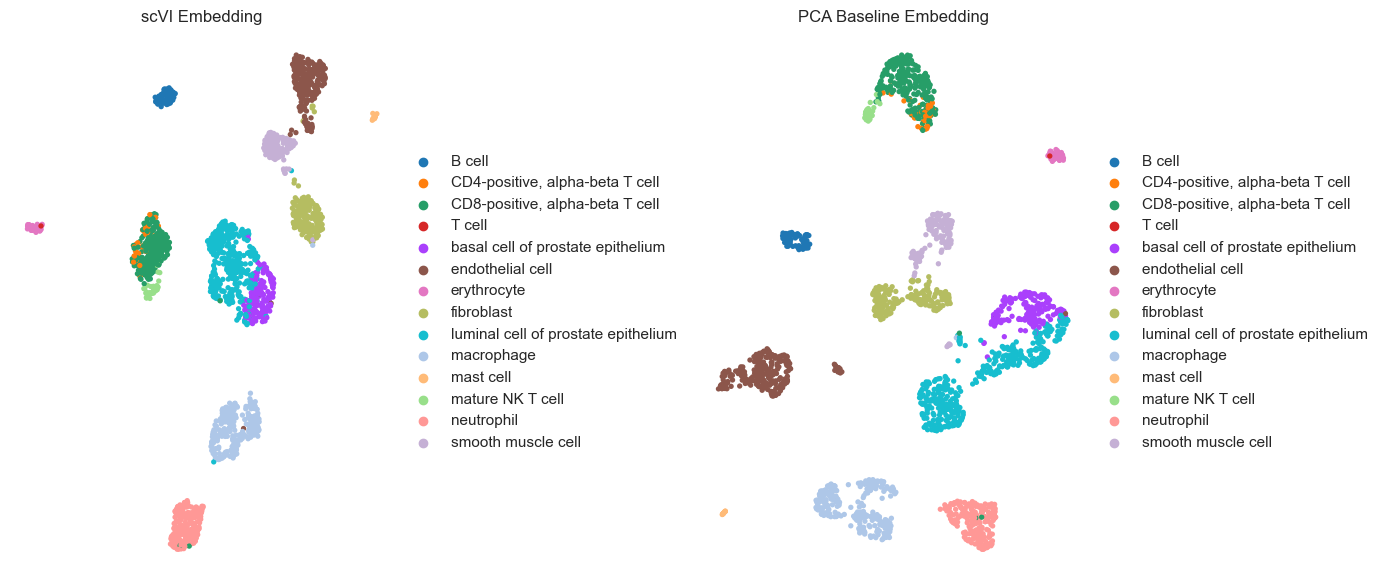

In [14]:

# UMAP Visualization: Show scVI and PCA baseline embeddings side by side

import scanpy as sc

def plot_umap(embedding, labels, title, ax):
    adata_vis = sc.AnnData(embedding)
    adata_vis.obs["cell_type"] = labels.values.astype(str)
    sc.pp.neighbors(adata_vis, use_rep="X")
    sc.tl.umap(adata_vis)
    sc.pl.umap(
        adata_vis,
        color="cell_type",
        title=title,
        frameon=False,
        show=False,
        legend_loc='right margin',
        ax=ax
    )

print("Generating UMAP visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_umap(model_output, dataset.labels, "UMAP: scVI Embedding", axes[0])
axes[0].set_title("scVI Embedding")

plot_umap(clustering_baseline, dataset.labels, "UMAP: PCA Baseline", axes[1])
axes[1].set_title("PCA Baseline Embedding")

plt.tight_layout()
plt.show()


### Step 4B: Run Embedding Tasks

In [10]:
all_results = {}
# Get raw expression data for baseline computation
expression_data = dataset.adata.X

# --- Run Embedding Task ---
embedding_task = EmbeddingTask()
embedding_task_input = EmbeddingTaskInput(input_labels=dataset.labels)
embedding_results_model = embedding_task.run(model_output, embedding_task_input)
embedding_baseline = embedding_task.compute_baseline(expression_data)
embedding_results_baseline = embedding_task.run(
    embedding_baseline, embedding_task_input
)

# Store results
all_results["embedding"] = {
    "model": [r.model_dump() for r in embedding_results_model],
    "baseline": [r.model_dump() for r in embedding_results_baseline],
}

INFO:2025-07-29 17:27:06,512:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/sgupta/.pyenv/versions/3

                   metric_type     value params        source  \
0  MetricType.SILHOUETTE_SCORE  0.627913     {}    scVI Model   
0  MetricType.SILHOUETTE_SCORE  0.650182     {}  PCA Baseline   

        metric_name  
0  SILHOUETTE_SCORE  
0  SILHOUETTE_SCORE  


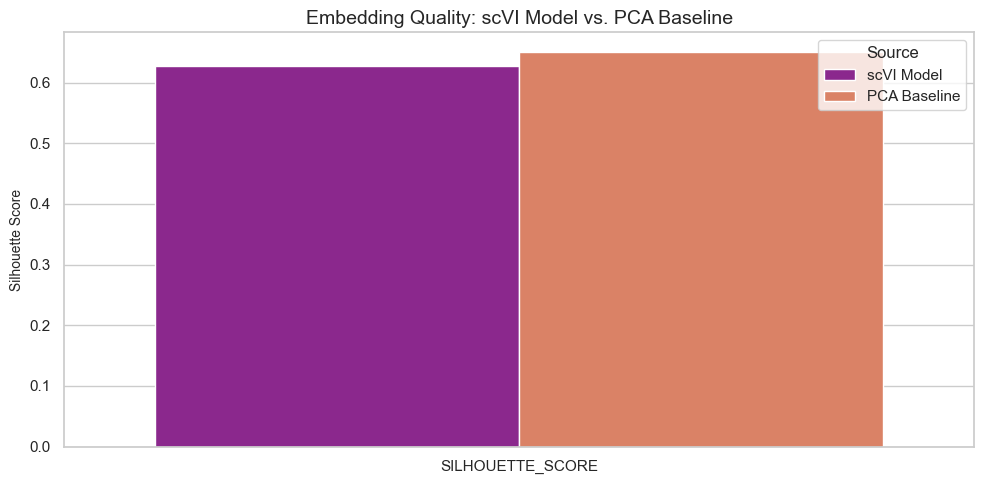

In [11]:
# Visualize Embedding Results
df_embedding_model = pd.DataFrame(all_results["embedding"]["model"])
df_embedding_baseline = pd.DataFrame(all_results["embedding"]["baseline"])
df_embedding_model["source"] = "scVI Model"
df_embedding_baseline["source"] = "PCA Baseline"
df_embedding = pd.concat([df_embedding_model, df_embedding_baseline])
df_embedding["metric_name"] = df_embedding["metric_type"].apply(lambda x: x.name)
print(df_embedding)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_embedding, x="metric_name", y="value", hue="source", palette="plasma")
plt.title("Embedding Quality: scVI Model vs. PCA Baseline", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=10)
plt.xlabel("")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

### Step 4C: Run Cell Type Classification Tasks

In [12]:
all_results = {}
# --- Run Prediction Task ---
# Run prediction task for model and baseline
prediction_task = MetadataLabelPredictionTask()
prediction_task_input = MetadataLabelPredictionTaskInput(labels=dataset.labels)
prediction_results_model = prediction_task.run(model_output, prediction_task_input)
prediction_baseline = prediction_task.compute_baseline(expression_data)
prediction_results_baseline = prediction_task.run(
    prediction_baseline, prediction_task_input
)

# Store results
all_results["prediction"] = {
    "model": [r.model_dump() for r in prediction_results_model],
    "baseline": [r.model_dump() for r in prediction_results_baseline],
}

INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 50), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 50) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for knn...
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for rf...
INFO:czbenchmarks.tasks.label_predic

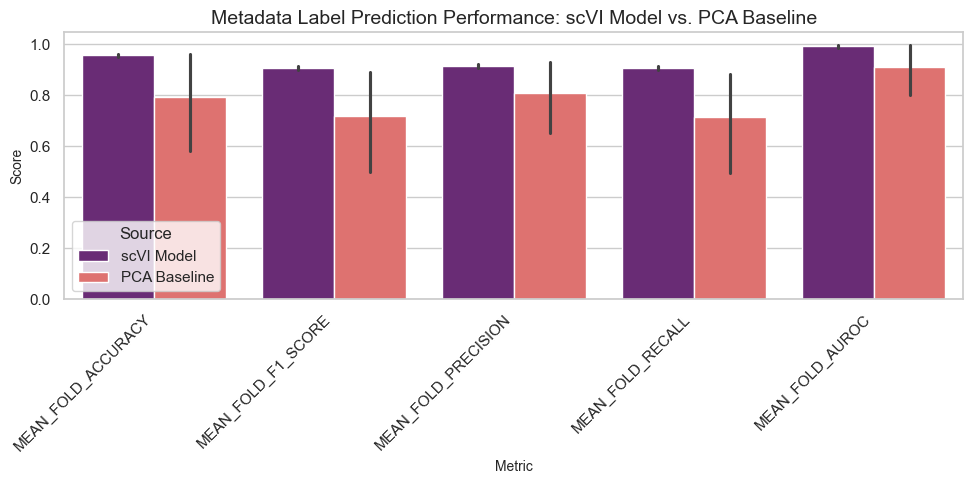

In [13]:
# Visualize Prediction Results
df_pred_model = pd.DataFrame(all_results["prediction"]["model"])
df_pred_baseline = pd.DataFrame(all_results["prediction"]["baseline"])
df_pred_model["source"] = "scVI Model"
df_pred_baseline["source"] = "PCA Baseline"
df_pred = pd.concat([df_pred_model, df_pred_baseline])
df_pred["metric_name"] = df_pred["metric_type"].apply(lambda x: x.name)
df_pred["classifier"] = df_pred["params"].apply(
    lambda p: p.get("classifier", "Overall")
)

#print(df_pred)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_pred, x="metric_name", y="value", hue="source", palette="magma")
plt.title(
    "Metadata Label Prediction Performance: scVI Model vs. PCA Baseline", fontsize=14
)
plt.ylabel("Score", fontsize=10)
plt.xlabel("Metric", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

### Results Interpretation

The benchmarking results provide insights into the performance of the scVI model compared to a PCA baseline across three tasks:

1. **Clustering**: Metrics such as Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) indicate how well the model groups cells into clusters.
2. **Embedding**: Silhouette scores measure the quality of embeddings, reflecting how well-separated cell types are in the latent space.
3. **Cell Type Classification**: Accuracy and F1 scores evaluate the model's ability to predict cell types based on metadata.

Higher scores for the scVI model compared to the PCA baseline suggest that the model captures biological variation more effectively.